In [1]:
!pip install cookiecutter-data-science

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/98.2 kB ? eta -:--:--
   ------------------------------------- -- 92.2/98.2 kB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 98.2/98.2 kB 1.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/243.2 kB ? eta -:--:--
   ---------------------------------------- 243.2/243.2 kB 5.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/199.4 kB ? eta -:--:--
   ---------------------------------------- 199.4/199.4 kB ? eta 0:00:00
   ---------------------------------------- 0.0/87.5 kB ? eta -:--:--
   ---------------------------------------- 87.5/87.5 kB ? eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import zipfile
from pathlib import Path
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

dataset_name = "shahnawaj9/diabetes-database"
download_folder = Path("data/diabetes-database")
download_folder.mkdir(parents=True, exist_ok=True)

api.dataset_download_files(dataset_name, path=str(download_folder), unzip=True)

Dataset URL: https://www.kaggle.com/datasets/shahnawaj9/diabetes-database


In [3]:
!dir "./data/diabetes-database"

 Volume in drive C has no label.
 Volume Serial Number is A4CB-2127

 Directory of c:\Users\Kinga\Documents\ARISA\MLOPs-Final\data\diabetes-database

08.05.2025  17:59    <DIR>          .
08.05.2025  17:59    <DIR>          ..
08.05.2025  17:59            23�873 diabetes.csv
08.05.2025  17:59            23�290 diabetes_Dataset_cleaned.csv
               2 File(s)         47�163 bytes
               2 Dir(s)  180�057�423�872 bytes free


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv(download_folder / "diabetes.csv")

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

y_train = df_train.pop("Outcome")
X_train = df_train

y_test = df_test.pop("Outcome")
X_test = df_test


In [5]:
import joblib
import optuna
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool, cv

outfolder = Path("results")
outfolder.mkdir(parents=True, exist_ok=True)

best_params_path = outfolder / "best_params.pkl"

if not best_params_path.is_file():
    X_train_opt, X_val_opt, y_train_opt, y_val_opt = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
    
    def objective(trial):
        params = {
            "depth": trial.suggest_int("depth", 2, 10),
            "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.3),
            "iterations": trial.suggest_int("iterations", 100, 300),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-5, 100.0, log=True),
            "bagging_temperature": trial.suggest_float("bagging_temperature", 0.01, 1),
            "random_strength": trial.suggest_float("random_strength", 1e-5, 100.0, log=True)
        }
        model = CatBoostClassifier(**params, verbose=0)
        model.fit(X_train_opt, y_train_opt, eval_set=(X_val_opt, y_val_opt), early_stopping_rounds=50)
        return model.get_best_score()["validation"]["Logloss"]
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=50)
    
    joblib.dump(study.best_params, best_params_path)
    params = study.best_params
else:
    params = joblib.load(best_params_path)
print("Best Parameters:", params)

Best Parameters: {'depth': 2, 'learning_rate': 0.24622239796003295, 'iterations': 177, 'l2_leaf_reg': 0.2807470766695133, 'bagging_temperature': 0.26445238306400015, 'random_strength': 0.0002363854018169984}


In [6]:
params["eval_metric"] = "F1"
params["loss_function"] = "Logloss"

model = CatBoostClassifier(
    **params,
    verbose=True
)

data = Pool(X_train, y_train)

cv_results = cv(
    params=params,
    pool=data,
    fold_count=5,
    partition_random_seed=42,
    shuffle=True,
)

cv_results.to_csv(outfolder / "cv_results_v2.csv", index=False)

Training on fold [0/5]
0:	learn: 0.5384615	test: 0.5833333	best: 0.5833333 (0)	total: 148ms	remaining: 26s
1:	learn: 0.5898305	test: 0.6842105	best: 0.6842105 (1)	total: 151ms	remaining: 13.2s
2:	learn: 0.5971223	test: 0.6666667	best: 0.6842105 (1)	total: 154ms	remaining: 8.91s
3:	learn: 0.5546875	test: 0.5846154	best: 0.6842105 (1)	total: 157ms	remaining: 6.79s
4:	learn: 0.5942029	test: 0.6849315	best: 0.6849315 (4)	total: 160ms	remaining: 5.51s
5:	learn: 0.6197183	test: 0.6849315	best: 0.6849315 (4)	total: 163ms	remaining: 4.65s
6:	learn: 0.6363636	test: 0.7027027	best: 0.7027027 (6)	total: 166ms	remaining: 4.04s
7:	learn: 0.6148410	test: 0.6944444	best: 0.7027027 (6)	total: 169ms	remaining: 3.58s
8:	learn: 0.6478873	test: 0.7027027	best: 0.7027027 (6)	total: 173ms	remaining: 3.23s
9:	learn: 0.6411150	test: 0.6933333	best: 0.7027027 (6)	total: 176ms	remaining: 2.94s
10:	learn: 0.6480836	test: 0.7012987	best: 0.7027027 (6)	total: 178ms	remaining: 2.68s
11:	learn: 0.6712803	test: 0.693

In [7]:
import plotly.graph_objects as go

# Create figure
fig = go.Figure()

# Add mean performance line
fig.add_trace(
    go.Scatter(
        x=cv_results["iterations"], y=cv_results["test-F1-mean"], mode="lines", name="Mean F1 Score", line=dict(color="blue")
    )
)

# Add shaded error region
fig.add_trace(
    go.Scatter(
        x=pd.concat([cv_results["iterations"], cv_results["iterations"][::-1]]),
        y=pd.concat([cv_results["test-F1-mean"]+cv_results["test-F1-std"], 
                     cv_results["test-F1-mean"]-cv_results["test-F1-std"]]),
        fill="toself", 
        fillcolor="rgba(0, 0, 255, 0.2)",
        line=dict(color="rgba(255, 255, 255, 0)"),
        showlegend=False
    )
)

# Customize layout
fig.update_layout(
    title="Cross-Validation (N=5) Mean F1 score with Error Bands",
    xaxis_title="Training Steps",
    yaxis_title="Performance Score",
    template="plotly_white",
    yaxis=dict(range=[0.5, 1])
)

fig.show()

fig.write_image(outfolder / "test_f1_v2.png")

In [8]:
import plotly.graph_objects as go

# Create figure
fig = go.Figure()

# Add mean performance line
fig.add_trace(
    go.Scatter(
        x=cv_results["iterations"], y=cv_results["test-Logloss-mean"], mode="lines", name="Mean logloss", line=dict(color="blue")
    )
)

# Add shaded error region
fig.add_trace(
    go.Scatter(
        x=pd.concat([cv_results["iterations"], cv_results["iterations"][::-1]]),
        y=pd.concat([cv_results["test-Logloss-mean"]+cv_results["test-Logloss-std"], 
                     cv_results["test-Logloss-mean"]-cv_results["test-Logloss-std"]]),
        fill="toself", 
        fillcolor="rgba(0, 0, 255, 0.2)",
        line=dict(color="rgba(255, 255, 255, 0)"),
        showlegend=False
    )
)

# Customize layout
fig.update_layout(
    title="Cross-Validation (N=5) Mean Logloss with Error Bands",
    xaxis_title="Training Steps",
    yaxis_title="Logloss",
    template="plotly_white"
)

fig.show()

fig.write_image(outfolder / "test_logloss_v2.png")

In [9]:
model.fit(
    X_train,
    y_train,
    verbose_eval=50,
    early_stopping_rounds=50,
    use_best_model=False,
    plot=True
)

model.save_model(outfolder / 'catboost_model_diabetes_v2.cbm')
joblib.dump(params, outfolder / 'model_params_v2.pkl')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5549133	total: 753us	remaining: 133ms
50:	learn: 0.7621483	total: 77.6ms	remaining: 192ms
100:	learn: 0.8190955	total: 109ms	remaining: 82.4ms
150:	learn: 0.8585608	total: 135ms	remaining: 23.2ms
176:	learn: 0.8811881	total: 148ms	remaining: 0us


['results\\model_params_v2.pkl']

In [10]:
model.predict(df_test)

array([1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [11]:
preds = model.predict(df_test[X_train.columns])

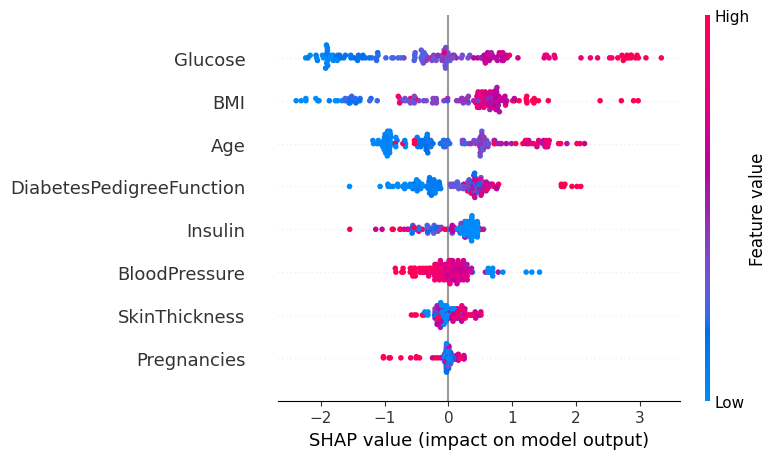

In [12]:
import shap
import matplotlib.pyplot as plt
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(df_test)

shap.summary_plot(shap_values, df_test, show=False)
plt.savefig(outfolder / "test_shap_overall_v2.png")

In [13]:
df_test["target"] = preds
df_test.to_csv(outfolder / "predictions_v2.csv", index=False)